# Multi Layer Perceptron

パーセプトロンを複数レイヤーつなげて、学習させてみる。活性化関数としては、reluを使い、最後の評価は`L.Classifier`のデフォルトで使うことにする。最適化アルゴリズムはAdamを使う。

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

In [2]:
import pickle, gzip
f = gzip.open('../data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(len(train_set[0]), len(valid_set[0]), len(test_set[0]))
train_set_x, train_set_y  = train_set
test_set_x, test_set_y = test_set
print(len(train_set_x[0]))
print(train_set_x)
print("28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている",train_set_x[:5])
print("最初のラベルは",train_set_y[0])

train_noise_set_x = np.array(train_set_x)
noise_ratio = 0.2
for data in train_noise_set_x:
    perm = np.random.permutation(train_noise_set_x.shape[1])[:int(train_noise_set_x.shape[1]*noise_ratio)]
    data[perm] = 0.0

# あとで、softmax_cross_entropyを使うときに型の判定があり、np.int32じゃないといけない
train_set_y = train_set_y.astype(np.int32)
test_set_y = test_set_y.astype(np.int32)
print(train_set_y )
f.close()

50000 10000 10000
784
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
最初のラベルは 5
[5 0 4 ..., 8 4 8]


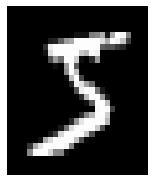

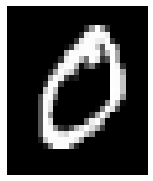

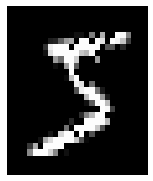

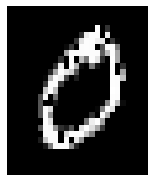

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
def draw_digit(data, size=28):
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1)
    plt.ylim(0,size-1)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

draw_digit(train_set_x[0])
draw_digit(train_set_x[1])
draw_digit(train_noise_set_x[0])
draw_digit(train_noise_set_x[1])

In [4]:
class MNISTMLPerceptron(Chain):
    def __init__(self, hidden_num=1024, input_num = 784, output_num = 10):
        super(MNISTMLPerceptron, self).__init__(
            l1 = L.Linear(input_num, hidden_num),
            l2 = L.Linear(hidden_num, hidden_num),
            l3 = L.Linear(hidden_num, output_num)
        )
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
    
model = L.Classifier(MNISTMLPerceptron())

In [5]:
optimizer = optimizers.Adam()
optimizer.setup(model)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)
    

0 0.10000000149011612
100 0.9100000262260437
200 0.9300000071525574
300 0.9900000095367432
400 0.9100000262260437
500 0.9700000286102295
600 0.9900000095367432
700 0.9800000190734863
800 0.9800000190734863
900 0.9900000095367432
1000 0.9800000190734863


In [6]:
model(Variable(test_set_x),Variable(test_set_y))
print("精度 →",model.accuracy.data)

精度 → 0.9700000286102295


97%ぐらいの制度が出る

次は、各層にdropoutを入れてみる。これは一般的には過学習を防ぐためと言われている。

In [7]:
class MNISTMLPerceptronDropout(MNISTMLPerceptron):
    def __init__(self, h_num = 1024, i_num = 784, o_num=10 ,train=True):
        super().__init__(h_num,i_num, o_num)
        self.train = train
    
    def __call__(self, x):
        h1 = F.dropout(F.relu(self.l1(x)), train=self.train)
        h2 = F.dropout(F.relu(self.l2(h1)), train=self.train)
        return self.l3(h2)

In [8]:
model = L.Classifier(MNISTMLPerceptronDropout())
optimizer.setup(model)
batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)

0 0.05999999865889549
100 0.8600000143051147
200 0.8500000238418579
300 0.9200000166893005
400 0.9399999976158142
500 0.9700000286102295
600 0.9300000071525574
700 0.9599999785423279
800 0.9599999785423279
900 0.9399999976158142
1000 0.9800000190734863


In [9]:
model.predictor.train = False
model(Variable(test_set_x),Variable(test_set_y))
print("精度 →",model.accuracy.data)

精度 → 0.97079998254776


ちょっと上がった？あんまり変わらないかも。dropout関数にtrainというフラグがあるからこれは予想するときには変えるべきってことよね。ここはChainer側でなんとかしてほしいなぁって思ったりする。

# Autoencoderのファインチューニング

ニューラルネットワークの階層が深くなっていくと、学習の速度が遅くなっていくことが知られている。それはパメーターの更新時が、深い階層で消失してしまうためであろうと考えられている。

そのための対策法として、プレ学習というものが使われることがあり、その手法としてAutoencoderという教師なし学習が使われることがある。

Autoencoderは入力層をそっくりそのまま出力層で再現するニューラルネットワークで、その学習したパラメーターを初期値として、クラス分類のニューラルネットワークを作ろうとする。

そうすることにより、よりよい学習が行われる。

まずはAutoencorderを作ってみる

In [10]:
class Autoencoder(Chain):
    def __init__(self, input_layer_num = 784, hidden_layer_num=1024):
        super(Autoencoder, self).__init__(
            l1 = L.Linear(input_layer_num, hidden_layer_num),
            l2 = L.Linear(hidden_layer_num, input_layer_num)
        )
        
    def __call__(self, x):
        h2 = self.predict(x)
        self.accuracy = F.mean_squared_error(h2, x)
        return self.accuracy
    
    def predict(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [11]:
a1 = Autoencoder()
optimizer = optimizers.Adam()
optimizer.setup(a1)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    optimizer.update(a1, batch_x)
    if step % 100 == 0:
        print(step, a1.accuracy.data)

0 0.14492611587047577
100 0.011946389451622963
200 0.006301306188106537
300 0.0044661653228104115
400 0.003947117831557989
500 0.00295453192666173
600 0.0023703405167907476
700 0.002556109568104148
800 0.0023129272740334272
900 0.001894674845971167
1000 0.001582900295034051


In [12]:
predict1 = a1.predict(Variable(test_set_x))

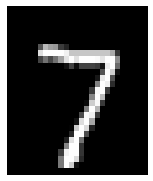

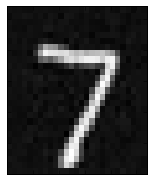

In [13]:
draw_digit(test_set_x[0])
draw_digit(predict1.data[0])

In [14]:
modelFromAE = L.Classifier(MNISTMLPerceptron())
modelFromAE.predictor.l1 = a1.l1.copy()
print(modelFromAE.predictor.l1.W.data == a1.l1.W.data)

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


確かにl1にパラメーターが写っていることがわかる

In [15]:
optimizer = optimizers.Adam()
optimizer.setup(modelFromAE)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(modelFromAE, batch_x, batch_y)
    if step % 100 == 0:
        print(step, modelFromAE.accuracy.data)

0 0.17000000178813934
100 0.9399999976158142
200 0.9900000095367432
300 0.9399999976158142
400 0.9800000190734863
500 0.9599999785423279
600 0.9800000190734863
700 1.0
800 0.9800000190734863
900 1.0
1000 0.9599999785423279


In [16]:
modelFromAE(Variable(test_set_x),Variable(test_set_y))
print("精度 →",modelFromAE.accuracy.data)

精度 → 0.9733999967575073


階層がそれほど深くないからか、あまり意味がなかった？また、Autoencoderはdenoisingではないので、そこが原因かもしれない？

テストデータをノイズを加えたものにして、Donoisingにしてみる

In [17]:
noise_a = Autoencoder()
optimizer = optimizers.Adam()
optimizer.setup(noise_a)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_noise_set_x[batch_index:batch_index+batch_size])
    optimizer.update(noise_a, batch_x)
    if step % 100 == 0:
        print(step, noise_a.accuracy.data)

0 0.12475860863924026
100 0.02181253395974636
200 0.011941920034587383
300 0.007841603830456734
400 0.004120602738112211
500 0.0032405350357294083
600 0.0028521965723484755
700 0.00199731532484293
800 0.001375194056890905
900 0.0016965472605079412
1000 0.0013334809336811304


In [18]:
modelFromAE = L.Classifier(MNISTMLPerceptron())
modelFromAE.predictor.l1 = noise_a.l1.copy()
optimizer = optimizers.Adam()
optimizer.setup(modelFromAE)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(modelFromAE, batch_x, batch_y)
    if step % 100 == 0:
        print(step, modelFromAE.accuracy.data)
        
modelFromAE.train = False
modelFromAE(Variable(test_set_x),Variable(test_set_y))
print("精度 →",modelFromAE.accuracy.data)

0 0.07999999821186066
100 0.8799999952316284
200 0.9200000166893005
300 0.9599999785423279
400 0.8899999856948853
500 0.9300000071525574
600 0.9599999785423279
700 0.9599999785423279
800 0.9800000190734863
900 0.9800000190734863
1000 1.0
精度 → 0.9732999801635742


AutoEncoderにノイズを加えてもそれほどよくならなかった。

In [19]:
modelFromAE = L.Classifier(MNISTMLPerceptron())
modelFromAE.predictor.l1 = noise_a.l1.copy()
optimizer = optimizers.Adam()
optimizer.setup(modelFromAE)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_noise_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(modelFromAE, batch_x, batch_y)
    if step % 100 == 0:
        print(step, modelFromAE.accuracy.data)
        
modelFromAE.train = False
modelFromAE(Variable(test_set_x),Variable(test_set_y))
print("精度 →",modelFromAE.accuracy.data)

0 0.07000000029802322
100 0.9100000262260437
200 0.9700000286102295
300 0.9800000190734863
400 0.9700000286102295
500 0.9800000190734863
600 0.9900000095367432
700 0.9599999785423279
800 1.0
900 1.0
1000 0.9900000095367432
精度 → 0.9782000184059143


最後に全部を合わせてみる

In [20]:
modelFromAE = L.Classifier(MNISTMLPerceptronDropout())
modelFromAE.predictor.l1 = noise_a.l1.copy()
optimizer = optimizers.Adam()
optimizer.setup(modelFromAE)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_noise_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(modelFromAE, batch_x, batch_y)
    if step % 100 == 0:
        print(step, modelFromAE.accuracy.data)
        
modelFromAE.train = False
modelFromAE(Variable(test_set_x),Variable(test_set_y))
print("精度 →",modelFromAE.accuracy.data)

0 0.10999999940395355
100 0.9800000190734863
200 0.9700000286102295
300 0.9599999785423279
400 0.9700000286102295
500 0.9800000190734863
600 0.949999988079071
700 0.9900000095367432
800 0.9599999785423279
900 0.949999988079071
1000 0.9700000286102295
精度 → 0.9632999897003174


うむ。。。難しい。。。